In [1]:
#@title Importing Packages
import random
random.seed(365)
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
#@title Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#@title Fashion MNIST

In [4]:
#@title Parameters
#LinearModel/nlModel/lnnModel/dnnModel
model_name = 'dnnModel' #@param {'type': 'string'}
batch_size = 64
epochs = 100
learning_rate = 0.01
optimizer_name ='SGD'

**Load Dataset**

In [5]:
#image transform and normalization
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))])

#defining train and test sets.
trainset = torchvision.datasets.FashionMNIST('data',
                                             download=True,
                                             train=True,
                                             transform=transform)
testset = torchvision.datasets.FashionMNIST('data',
                                            download=True,
                                            train=False,
                                            transform=transform)
#Creating dataloaders for both training and testing
trainloader = torch.utils.data.DataLoader(trainset,batch_size = batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size = batch_size,
                                         shuffle=False)

#constant for different classes in the dataset
classes = ('T-shirt/top','Trouser','Pullover','Dress','Coat'
      ,'Sandal','Shirt','Sneaker','Bag','Ankle Boot')

#function to show an image
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img=img.mean(dim=0)
  img = img/2 + 0.5 #unnormalize
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg, (1,2,0)))


**Visualizing Training Examples**

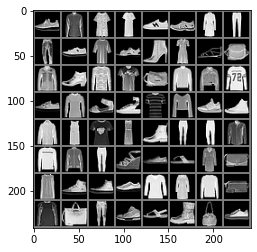

In [6]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
matplotlib_imshow(torchvision.utils.make_grid(images))

In [7]:
class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784,256)
    self.fc2 = nn.Linear(256,10)

  def forward(self,x):
    #flattening the input tensor
    x=x.view(x.shape[0],-1)
    x=self.fc1(x)
    x=F.log_softmax(self.fc2(x),dim=1)

    return x


In [8]:
class nlModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784,256)
    self.fc2 = nn.Linear(256,10)

  def forward(self,x):
    #flattening the input tensor
    x=x.view(x.shape[0],-1)
    x=F.relu(self.fc1(x))
    x=F.log_softmax(self.fc2(x),dim=1)

    return x


In [9]:
class LNN_Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784,256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,10)

  def forward(self,x):
    #flattening the input tensor
    x=x.view(x.shape[0],-1)
    x=self.fc1(x)
    x=self.fc2(x)
    x=self.fc3(x)
    x=F.log_softmax(self.fc4(x),dim=1)

    return x


In [10]:
# #@title NTK
# #install JAX on CPU by running
# !pip install jax jaxlib --upgrade
# #Once JAX is installed install Neural Tangents by running
# !pip install neural-tangents

**DNN Architecture**

In [11]:
#Class for the model and subclassing nn.Module to use the layers available
class DNN_Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784,256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,10)

  def forward(self,x):
    #flattening the input tensor
    x=x.view(x.shape[0],-1)
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=F.relu(self.fc3(x))
    x=F.log_softmax(self.fc4(x),dim=1)

    return x


In [12]:
if model_name == 'LinearModel':
  model = LinearModel().to(device)
if model_name == 'nlModel':
  model = nlModel().to(device)  
if model_name == 'lnnModel':
  model = LNN_Classifier().to(device)
if model_name == 'dnnModel':
  model = DNN_Classifier().to(device) 

**Loss function and optimizer**

In [13]:
#metric for loss function
criterion = nn.NLLLoss()
#selecting optimizer
if optimizer_name == 'SGD':
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)
if optimizer_name == 'Adam':
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Gradient computation(optional)

In [14]:
# images,labels = iter(trainloader).next()
# log_ps = model(images.to(device))
# loss = criterion(log_ps,labels.to(device))
# loss.backward()
# print(model.fc1.weight.grad)

**Training Loop**

In [15]:
for e in range(epochs):
  running_loss = 0
  model.train()
  for images,labels in trainloader:
    log_ps = model(images.to(device))
    loss = criterion(log_ps,labels.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
  else:
    print(f"Epoch[{e+1}/{epochs}]: Training loss:{running_loss/1000}",end=" ")

    #evaluation
    model.eval()
    with torch.no_grad():
      total = 0
      correct = 0
      for images,labels in testloader:
        log_ps = model(images.to(device)).cpu()
        max_index = torch.argmax(log_ps,dim=1)
        total+=labels.numel()
        correct+=sum(max_index==labels).item()
      print(f"Test Accuracy {correct/total*100:.2f}")

Epoch[1/100]: Training loss:1.302642914235592 Test Accuracy 72.13
Epoch[2/100]: Training loss:0.5786883206665516 Test Accuracy 76.87
Epoch[3/100]: Training loss:0.49333061090111735 Test Accuracy 80.47
Epoch[4/100]: Training loss:0.45084468300640584 Test Accuracy 81.79
Epoch[5/100]: Training loss:0.4231299847215414 Test Accuracy 82.55
Epoch[6/100]: Training loss:0.4028109694123268 Test Accuracy 83.53
Epoch[7/100]: Training loss:0.3856200533509254 Test Accuracy 83.78
Epoch[8/100]: Training loss:0.37100618045032024 Test Accuracy 83.90
Epoch[9/100]: Training loss:0.3584593581110239 Test Accuracy 84.41
Epoch[10/100]: Training loss:0.34692179423570635 Test Accuracy 84.89
Epoch[11/100]: Training loss:0.3367907914966345 Test Accuracy 84.88
Epoch[12/100]: Training loss:0.32625438647717236 Test Accuracy 85.97
Epoch[13/100]: Training loss:0.31736726542562244 Test Accuracy 86.51
Epoch[14/100]: Training loss:0.30930763402581213 Test Accuracy 86.57
Epoch[15/100]: Training loss:0.30153589956462384 Te

In [ ]:
##RESULTS
#30 Epochs
#LinearModel(Model with only 1 linear layer containing 256 hidden nodes): 84.59 (20)
#nlModel(Model with only 1 non linear layer containing 256 hidden nodes): 87.67 (30)
#lnnModel(Model with only 3 linear layer containing 256,128,64 hidden nodes): 84.73 (19)
#dnnModel(Model with only 3 non linear layer containing 256,128,64 hidden nodes): 88.10(27)

#100 Epochs
#LinearModel(Model with only 1 linear layer containing 256 hidden nodes): 84.73 (87)
#nlModel(Model with only 1 non linear layer containing 256 hidden nodes): 89.32 (87)
#lnnModel(Model with only 3 linear layer containing 256,128,64 hidden nodes): 84.42(79)
#dnnModel(Model with only 3 non linear layer containing 256,128,64 hidden nodes): 89.21(91)